Importing the libraries required

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


Import Natural Language Processing Tool Kit and downloading the 'Stopwords'

In [2]:
import nltk
import ssl

In [4]:
ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/qasim_1478/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Importing the dataset

In [5]:
messages = [line.rstrip() for line in open('./SMSSpamCollection')]

Checking out the first 10 lines of the data set

In [6]:
for mess_no, message in enumerate(messages[:10]):
    print(mess_no,message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 

In [7]:
messages=pd.read_csv('./SMSSpamCollection',sep='\t',
                     names=['label','message'])

Exploring the data set

In [8]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [9]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Adding a length columns to find out the length of each message

In [10]:
messages['length']=messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [13]:
messages['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

Is there a relationship between the length of the message and it's label?

<AxesSubplot: ylabel='Frequency'>

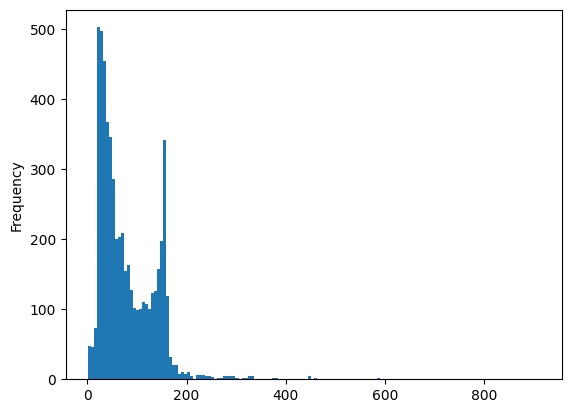

In [11]:
messages['length'].plot.hist(bins=150)

array([<AxesSubplot: title={'center': 'ham'}>,
       <AxesSubplot: title={'center': 'spam'}>], dtype=object)

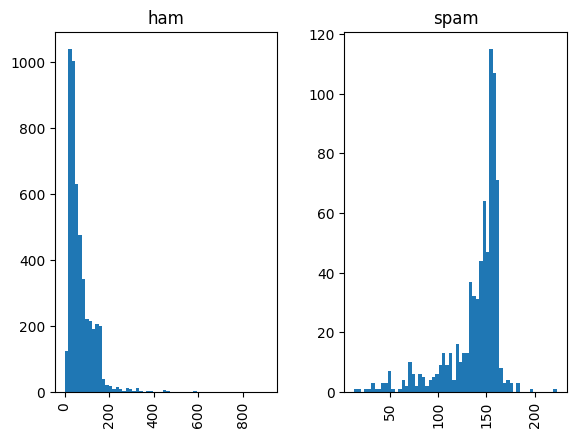

In [12]:
messages.hist(column='length',by='label',bins=60)

Now we have to create a function to do the following:
1- Remove Punctuations
2- Remove the stop words
3- Return list of clean text words

In [14]:
import string
from nltk.corpus import stopwords

In [15]:
def text_process(mess):
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return[word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [16]:
#Checking the function out:
messages['message'].head(5).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

We have to Vectorize the dataset now

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transform = CountVectorizer(analyzer=text_process).fit(messages['message']) #Bag Of words
messages_bow = bow_transform.transform(messages['message'])

Using the Term Frequency ID

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer
tfid_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfid_transformer.transform(messages_bow)

Now we can classify the text using Naive-Baye's Classifier

In [20]:
from sklearn.naive_bayes import MultinomialNB
spam_detect = MultinomialNB().fit(messages_tfidf,messages['label'])

In [21]:
all_pred = spam_detect.predict(messages_tfidf) #Making sure that the message is in the form of tfidf

Using a Train-Test Split 

In [22]:
from sklearn.model_selection import train_test_split
msg_train,msg_test,label_train,label_test = train_test_split(messages['message'],messages['label'])

Creating a pipeline to streamline the entire process:

In [25]:
from sklearn.pipeline import Pipeline
pipeline= Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [26]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x16834ce50>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

Checking out the performance metrics of the model:

In [27]:
predictions = pipeline.predict(msg_test)
from sklearn.metrics import classification_report
print(classification_report(label_test,predictions,))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1224
        spam       1.00      0.73      0.84       169

    accuracy                           0.97      1393
   macro avg       0.98      0.86      0.91      1393
weighted avg       0.97      0.97      0.96      1393

